## Rough Algorithm Idea:

* One CSV, per position, per year. Eg -> qb/2020.csv
* For each year:
  * Drop any columns that are probably not relevant, or will have little value (eg Bye, 2Pt)
  * Clean up columns that are duplicate, eg Pass Att vs Rush Att
  * Rename columns such that they are YEAR_XX, eg 2020_Cmp
* Merge the years by Player name column
* Now we've got our full set of data. Regularize and do feature engineering as needed
* Split up training/test etc to train model

In [ ]:
!pip install scikit-optimize

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from functools import reduce
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

%matplotlib inline


In [ ]:
# Get data
data_2020 = pd.read_csv("FF_2021/qb/2020.csv", thousands=',')
data_2019 = pd.read_csv("FF_2021/qb/2019.csv", thousands=',')
data_2018 = pd.read_csv("FF_2021/qb/2018.csv", thousands=',')
data_2017 = pd.read_csv("FF_2021/qb/2017.csv", thousands=',')
data_2016 = pd.read_csv("FF_2021/qb/2016.csv", thousands=',')

qb_data_years = [data_2020, data_2019, data_2018, data_2017, data_2016]

In [ ]:
# Clean/Merge all the data

year = 2020

# Clean up duplicate columns
# Drop columns that are likely not important based on football knowledge
for i in range(len(qb_data_years)):
    qb_data_years[i] = qb_data_years[i] \
        .rename(columns={"Att": "Pass_Att", "Yds": "Pass_Yds", "TD": "Pass_TD","Att.1": "Rush_Att", "Yds.1": "Rush_Yds", "TD.1": "Rush_TD"}) \
        .drop(columns=["Bye", "2Pt", "2Pt.1", "Rec", "Yds.2", "TD.2", "2Pt.2", "TD.3"])

    column_names = qb_data_years[i].columns.delete(0)
    for column in column_names:
        qb_data_years[i][column] = qb_data_years[i][column].astype(float)
        qb_data_years[i] = qb_data_years[i].rename(columns={column: str(year) + "_" + column})

    year -= 1

merged = reduce(lambda left,right: pd.merge(left,right, on=['Player'], how="outer"), qb_data_years).fillna(0)
# Drop all 2020 columns except points, as those will throw off the testing
merged = merged.drop(columns=["2020_Pass_Att", "2020_Cmp", "2020_Pass_Yds", "2020_Pass_TD", "2020_Int", "2020_Rush_Att", "2020_Rush_Yds", "2020_Rush_TD", "2020_FL"])


In [ ]:
merged

,Player,2020_Pts*,2019_Pts*,2019_Pass_Att,2019_Cmp,2019_Pass_Yds,2019_Pass_TD,2019_Int,2019_Rush_Att,2019_Rush_Yds,...,2016_Pts*,2016_Pass_Att,2016_Cmp,2016_Pass_Yds,2016_Pass_TD,2016_Int,2016_Rush_Att,2016_Rush_Yds,2016_Rush_TD,2016_FL
0,Aaron Rodgers,469.0,322.0,569.0,353.0,4002.0,26.0,4.0,46.0,183.0,...,449.0,610.0,401.0,4428.0,40.0,7.0,67.0,369.0,4.0,4.0
1,Josh Allen,461.0,318.0,461.0,271.0,3089.0,20.0,9.0,109.0,510.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Patrick Mahomes,439.0,329.0,484.0,319.0,4031.0,26.0,5.0,43.0,218.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Russell Wilson,428.0,379.0,516.0,341.0,4110.0,31.0,5.0,75.0,342.0,...,302.0,546.0,353.0,4219.0,21.0,11.0,72.0,259.0,1.0,2.0
4,Deshaun Watson,421.0,364.0,495.0,333.0,3852.0,26.0,12.0,82.0,413.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,Connor Cook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,21.0,14.0,150.0,1.0,1.0,0.0,0.0,0.0,1.0
130,Trevone Boykin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,18.0,13.0,145.0,1.0,1.0,8.0,1.0,0.0,0.0
131,Tony Romo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,4.0,3.0,29.0,1.0,0.0,0.0,0.0,0.0,0.0
132,Matt McGloin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,15.0,8.0,50.0,0.0,0.0,3.0,-3.0,0.0,0.0


In [ ]:
_deepnote_run_altair(merged, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"line","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"Player","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"2020_Pts*","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

[Text(0.5, 0, '2020_Pts*'),
 Text(1.5, 0, '2019_Pts*'),
 Text(2.5, 0, '2019_Pass_Att'),
 Text(3.5, 0, '2019_Cmp'),
 Text(4.5, 0, '2019_Pass_Yds'),
 Text(5.5, 0, '2019_Pass_TD'),
 Text(6.5, 0, '2019_Int'),
 Text(7.5, 0, '2019_Rush_Att'),
 Text(8.5, 0, '2019_Rush_Yds'),
 Text(9.5, 0, '2019_Rush_TD'),
 Text(10.5, 0, '2019_FL'),
 Text(11.5, 0, '2018_Pts*'),
 Text(12.5, 0, '2018_Pass_Att'),
 Text(13.5, 0, '2018_Cmp'),
 Text(14.5, 0, '2018_Pass_Yds'),
 Text(15.5, 0, '2018_Pass_TD'),
 Text(16.5, 0, '2018_Int'),
 Text(17.5, 0, '2018_Rush_Att'),
 Text(18.5, 0, '2018_Rush_Yds'),
 Text(19.5, 0, '2018_Rush_TD'),
 Text(20.5, 0, '2018_FL'),
 Text(21.5, 0, '2017_Pts*'),
 Text(22.5, 0, '2017_Pass_Att'),
 Text(23.5, 0, '2017_Cmp'),
 Text(24.5, 0, '2017_Pass_Yds'),
 Text(25.5, 0, '2017_Pass_TD'),
 Text(26.5, 0, '2017_Int'),
 Text(27.5, 0, '2017_Rush_Att'),
 Text(28.5, 0, '2017_Rush_Yds'),
 Text(29.5, 0, '2017_Rush_TD'),
 Text(30.5, 0, '2017_FL'),
 Text(31.5, 0, '2016_Pts*'),
 Text(32.5, 0, '2016_Pass_At

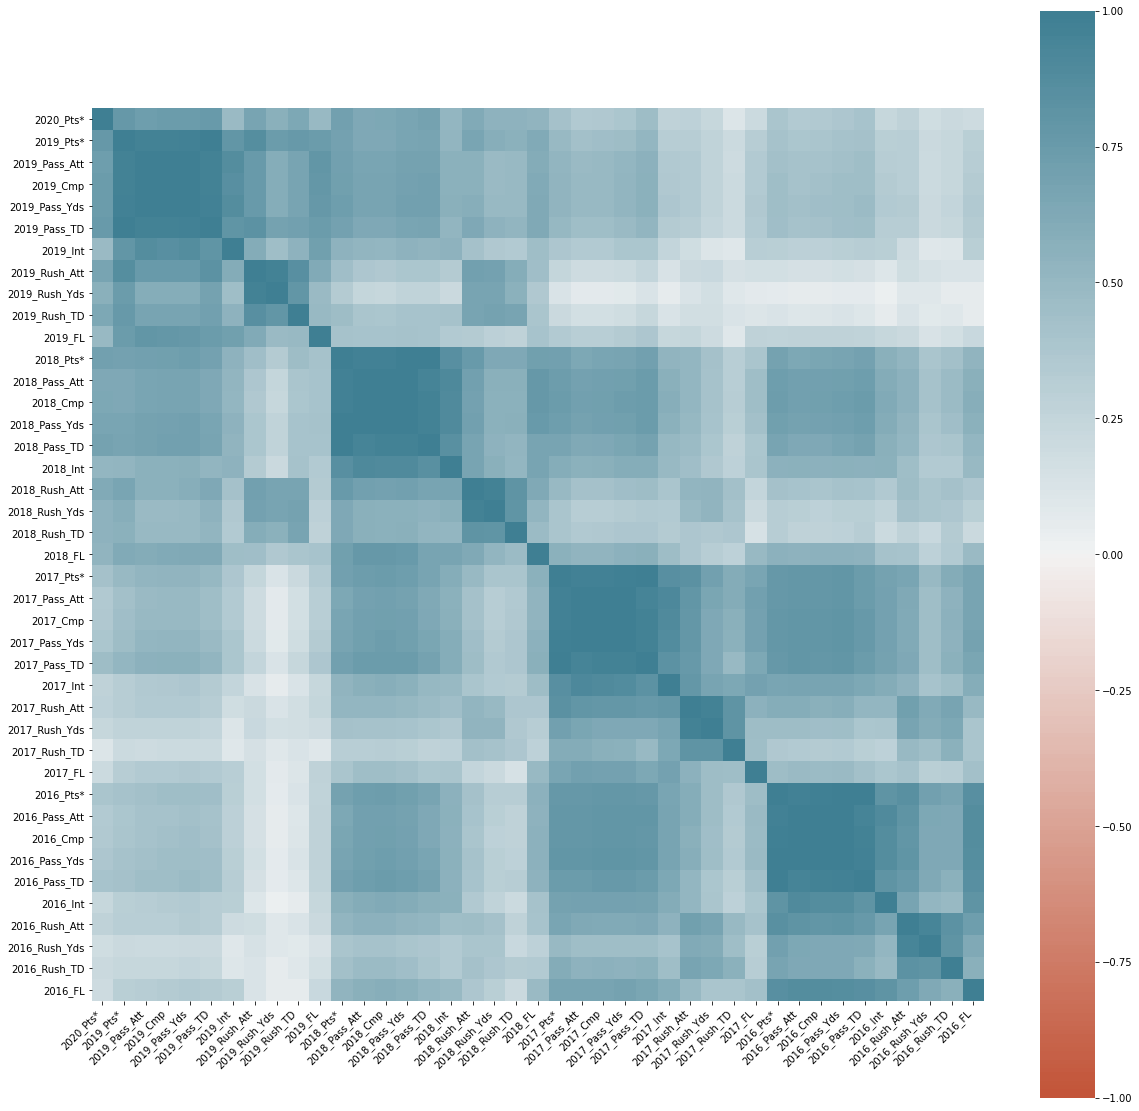

In [ ]:
# Data Exploration

# Correlation

corr = merged.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Results of Correlation
Based on the results, there is very little correlation between 2017 and 2016 data compared to 2020. We can probably drop that data to simplify the model. Below we'll recreate the merged data set with only 2018-2020 data.

Also, we'll rename the columns so _YEAR is after the column name, which makes it easier to access the columns via pandas.

In [ ]:
data_2020_2 = pd.read_csv("FF_2021/qb/2020.csv", thousands=',')
data_2019_2 = pd.read_csv("FF_2021/qb/2019.csv", thousands=',')
data_2018_2 = pd.read_csv("FF_2021/qb/2018.csv", thousands=',')

qb_data_years_2 = [data_2020_2, data_2019_2, data_2018_2]

# Clean/Merge all the data

year = 2020

# Clean up duplicate columns
# Drop columns that are likely not important based on football knowledge
for i in range(len(qb_data_years_2)):
    qb_data_years_2[i] = qb_data_years_2[i] \
        .rename(columns={"Pts*" : "Pts", "Att": "Pass_Att", "Yds": "Pass_Yds", "TD": "Pass_TD","Att.1": "Rush_Att", "Yds.1": "Rush_Yds", "TD.1": "Rush_TD"}) \
        .drop(columns=["Bye", "2Pt", "2Pt.1", "Rec", "Yds.2", "TD.2", "2Pt.2", "TD.3"])

    column_names = qb_data_years_2[i].columns.delete(0)
    for column in column_names:
        qb_data_years_2[i][column] = qb_data_years_2[i][column].astype(float)
        qb_data_years_2[i] = qb_data_years_2[i].rename(columns={column: column + "_" + str(year)})

    year -= 1

merged_2 = reduce(lambda left,right: pd.merge(left,right, on=['Player'], how="outer"), qb_data_years_2).fillna(0)
# Drop all 2020 columns except points, as those will throw off the testing
merged_2 = merged_2.drop(columns=["Pass_Att_2020", "Cmp_2020", "Pass_Yds_2020", "Pass_TD_2020", "Int_2020", "Rush_Att_2020", "Rush_Yds_2020", "Rush_TD_2020", "FL_2020"])




In [ ]:
# Drop all players with 0 fantasy points in 2020, they are likely outliers. This may cause issues with players that were legit injured
# but I'd rather not draft them regardless

merged_2 = merged_2[merged_2.Pts_2020 > 0]
merged_2

,Player,Pts_2020,Pts_2019,Pass_Att_2019,Cmp_2019,Pass_Yds_2019,Pass_TD_2019,Int_2019,Rush_Att_2019,Rush_Yds_2019,...,Pts_2018,Pass_Att_2018,Cmp_2018,Pass_Yds_2018,Pass_TD_2018,Int_2018,Rush_Att_2018,Rush_Yds_2018,Rush_TD_2018,FL_2018
0,Aaron Rodgers,469.0,322.0,569.0,353.0,4002.0,26.0,4.0,46.0,183.0,...,352.0,597.0,372.0,4442.0,25.0,2.0,43.0,269.0,2.0,3.0
1,Josh Allen,461.0,318.0,461.0,271.0,3089.0,20.0,9.0,109.0,510.0,...,218.0,320.0,169.0,2074.0,10.0,12.0,89.0,631.0,8.0,2.0
2,Patrick Mahomes,439.0,329.0,484.0,319.0,4031.0,26.0,5.0,43.0,218.0,...,507.0,580.0,383.0,5097.0,50.0,12.0,60.0,272.0,2.0,2.0
3,Russell Wilson,428.0,379.0,516.0,341.0,4110.0,31.0,5.0,75.0,342.0,...,359.0,427.0,280.0,3448.0,35.0,7.0,67.0,376.0,0.0,2.0
4,Deshaun Watson,421.0,364.0,495.0,333.0,3852.0,26.0,12.0,82.0,413.0,...,374.0,505.0,345.0,4165.0,26.0,9.0,99.0,551.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Logan Woodside,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,Geno Smith,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,4.0,1.0,8.0,0.0,0.0,8.0,2.0,0.0,1.0
71,Nathan Peterman,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,81.0,44.0,296.0,1.0,7.0,10.0,50.0,1.0,0.0
72,Case Keenum,1.0,125.0,247.0,160.0,1707.0,11.0,5.0,9.0,12.0,...,240.0,586.0,365.0,3890.0,18.0,15.0,26.0,93.0,2.0,2.0


In [ ]:
# Get the training data
train_data = merged_2.drop(["Player", "Pts_2020"],axis=1)
target_label = merged_2["Pts_2020"]

In [ ]:
# Time to optimize the hyperparameters

n_features = train_data.shape[1]
x_train, x_test, y_train, y_test = train_test_split(train_data, target_label, test_size = 0.30)

clf = ensemble.GradientBoostingRegressor(n_estimators=50, random_state=0)

space  = [Integer(1, 15, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print(clf_gp.fun)
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (clf_gp.x[0], clf_gp.x[1],
                            clf_gp.x[2], clf_gp.x[3],
                            clf_gp.x[4]))


62.41505487221897
Best parameters:
- max_depth=1
- learning_rate=0.284404
- max_features=20
- min_samples_split=7
- min_samples_leaf=1


In [ ]:
# Time for fun.

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.626205034441123

# Results
R^2 score of 0.28-0.42

As expected, looking at the past 2 years of basic stats data isn't very good at predicting how a player will perform.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d6ab167-ee9b-415e-918f-3bd37d7f66bf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>